<a href="https://colab.research.google.com/github/llayer/ml_exercise/blob/master/Higgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Higgs ML dataset studies

In [0]:
import pandas as pd
import numpy as np

In [6]:
!git clone https://github.com/llayer/ml_exercise

Cloning into 'ml_exercise'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 33 (delta 6), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [4]:
!pip3 install scikit-optimize

     |████████████████████████████████| 81kB 2.3MB/s 


## 1. Load data

In [0]:
sig = pd.read_hdf('ml_exercise/higgs_signal.h5')
bkg = pd.read_hdf('ml_exercise/higgs_bkg.h5')

In [8]:
sig.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_btag,jet3_pt,jet3_eta,jet3_phi,jet3_btag,jet4_pt,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,label
0,0.723801,-0.914611,0.910944,1.194830,-0.448292,0.839489,-0.871428,0.587799,0.000000,0.654446,1.159881,-0.725923,0.000000,0.422018,1.636800,-0.880565,0.000000,1.033994,-0.704196,-0.916982,3.101961,0.867059,1.127180,1.211664,0.695883,0.694068,0.755813,0.761658,0
1,1.974119,0.660297,-1.362428,1.234102,1.677716,1.478815,0.408940,-0.105273,0.000000,1.017048,-0.127190,0.363313,2.214872,0.918675,0.072083,1.162631,0.000000,0.961458,0.629154,1.604089,3.101961,1.938668,1.233898,0.990063,0.524871,0.900614,0.917613,1.083369,0
2,0.946889,0.169416,1.210014,0.343294,-1.579545,0.999435,1.030804,-0.475041,0.000000,0.435374,0.054457,-0.083982,0.000000,1.465033,0.613681,1.492698,2.548224,1.192695,0.190256,0.558635,3.101961,0.881641,0.845381,0.997408,0.695120,0.787132,0.657668,0.721147,0
3,1.298084,-0.897079,1.224441,0.618091,0.856746,0.493122,-0.021810,-1.520042,2.173076,0.973234,0.325470,-0.250431,2.214872,0.782569,-0.841807,-0.817325,0.000000,0.810789,-1.033162,0.581386,0.000000,0.848238,0.925814,0.973957,0.961469,0.946147,1.028120,0.848133,0
4,1.022289,-0.481195,0.169649,1.103255,0.744424,1.648197,-0.780327,-1.484007,2.173076,0.675472,0.507117,0.395493,0.000000,0.540036,0.139441,-0.549385,0.000000,0.802513,-1.164748,-0.284934,1.550981,0.717778,0.752909,0.996800,1.648921,1.138676,1.118826,0.977200,0


In [0]:
data = pd.concat([sig, bkg])

## 2. Feature importance with XGBoost

In [0]:
features = data.drop(['label'], axis=1).values
labels = data[['label']].values.ravel()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [12]:
import xgboost as xgb

# Early stopping
early_stopping_rounds = 5

# Define model
model_bdt = xgb.XGBClassifier(n_jobs = 4)

# Last in list is used for early stopping
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit with early stopping
model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
              early_stopping_rounds=early_stopping_rounds, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

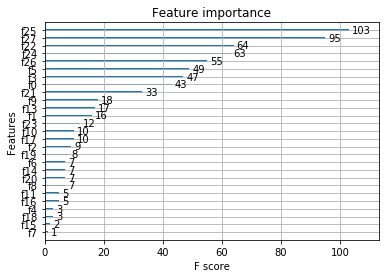

In [13]:
from xgboost import plot_importance
plot_importance(model_bdt)

In [0]:
fscore = list(model_bdt.feature_importances_)
feature_importance = pd.DataFrame(list(data.drop(['label'], axis=1)))
feature_importance['f-score'] = fscore
feature_importance.columns = ['feature', 'fscore']
feature_importance = feature_importance.sort_values(by=['fscore'], ascending=False)

In [15]:
feature_importance.head()

,feature,fscore
25,m_bb,0.147746
26,m_wbb,0.101843
27,m_wwbb,0.073595
5,jet1_pt,0.069575
22,m_jjj,0.068811


## Test algorithms

### Set up Bayesian optimization

In [0]:
import xgboost as xgb
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

def fit_lreg(X_train, y_train, X_test, y_test, p):

    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    predictions = model_bdt.clf(X_test)[:,1]
    return roc_auc_score(y_test, predictions)


def fit_xgboost(X_train, y_train, X_test, y_test, p):

    # Early stopping
    early_stopping_rounds = 10
    # Define model
    model_bdt = xgb.XGBClassifier(n_jobs = 4, n_estimators = 1000, learning_rate = p['learning_rate'],
                            max_depth = p['max_depth'], min_child_weight = p['min_child_weight'])
    # Last in list is used for early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]
    # Fit with early stopping
    model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
                    early_stopping_rounds=early_stopping_rounds, verbose=False)
    predictions = model_bdt.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, predictions)

def fit_keras(X_train, y_train, X_test, y_test, p):

    # Early stopping
    patience = 5
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
    
    # Define model
    model = create_model(features.shape[1], p['dense_layers'], p['dense_units'], 0., 
                            #p['regulizer_value'], 
                            p['dropout_value'], 
                            p['learning_rate'])
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 100,# p['batch_size'], 
                        epochs=1000, verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    return roc_auc_score(y_test, predictions)


def optimize( algo, dimensions, initial_param, data, cv = False, kfold_splits = 5, num_calls=12, random_state = 42): 

    prior_values = []
    prior_names = []
    for var in dimensions:
        name = var.name
        print( name )
        prior_names.append(name)
        prior_values.append(initial_param[name])

    global num_skopt_call
    num_skopt_call = 0
    #errors = []

    @use_named_args(dimensions)
    def fitness(**p): 

        global num_skopt_call

        print('\n \t ::: {} SKOPT CALL ::: \n'.format(num_skopt_call+1))
        print(p)

        reduced_feat = feature_importance.iloc[0:p['n_feat']]
        reduced_feat = list(reduced_feat['feature'])
        data_red = data[reduced_feat]
        features = data_red.values
        labels = data[['label']].values.ravel()

        if cv == False:
            X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=random_state)
            if algo == 'xgboost':
                score = fit_xgboost(X_train, y_train, X_test, y_test, p)
            if algo == 'keras':
                score = fit_keras(X_train, y_train, X_test, y_test, p)
            print(score)

        else:
            cv_scores = []    
            enum = enumerate(KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state).split(features,labels))
            for i,(index_train, index_valid) in enum:
                X_train, X_test = features[ index_train ], features[ index_valid ]
                y_train, y_test = labels[ index_train ], labels[ index_valid ]   
                if algo == 'xgboost':
                    score = fit_xgboost(X_train, y_train, X_test, y_test, p)
                if algo == 'keras':
                    score = fit_keras(X_train, y_train, X_test, y_test, p)
                cv_scores.append(score)
                print( cv_scores )
            score = np.mean(cv_scores)
            print(score)
            print(np.std(cv_scores))

        num_skopt_call += 1

        return -1*score

    search_result = gp_minimize( func = fitness, dimensions = dimensions,
                                 acq_func = 'EI', # Expected Improvement
                                 n_calls = num_calls, x0 = prior_values )

    params = pd.DataFrame(search_result['x_iters'])
    params.columns = [*prior_names]
    params = params.rename_axis('call').reset_index()
    scores = pd.DataFrame(search_result['func_vals'])
    scores.columns = ['score']
    result = pd.concat([params, scores], axis=1)
    result = result.sort_values(by=['score'])
    #errors_frame = pd.DataFrame(errors, columns = ['call', 'q_error', 't_error'])
    #result = pd.merge(result, errors_frame, on=['call'])   
    
    return result

### 1. XGBoost

In [0]:
from skopt.space import Real, Categorical, Integer

# Skopt dimensions
skopt_dims = [       
    Real(        low=1e-2, high=1,     prior='log-uniform', name='learning_rate'     ),
    Integer(        low=2,    high=20,                         name='max_depth'     ),
    Integer(        low=1,    high=20,                         name='min_child_weight'     ),
    Real(        low=1e-6, high=1e-2,     prior='log-uniform', name='reg_alpha'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]

# Initial parameters
init_param = {'learning_rate' : 0.3, 'reg_alpha' : 1e-5, 'max_depth' : 6, 'min_child_weight' : 1, 'n_feat':12 }

In [39]:
search_result = optimize('xgboost', skopt_dims, init_param, data, cv = True, num_calls=20, random_state = 42)

learning_rate
max_depth
min_child_weight
reg_alpha
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1e-05, 'n_feat': 12}
[0.7754328578154179]
[0.7754328578154179, 0.7919428262996222]
[0.7754328578154179, 0.7919428262996222, 0.779414937729251]
[0.7754328578154179, 0.7919428262996222, 0.779414937729251, 0.7957423210858326]
[0.7754328578154179, 0.7919428262996222, 0.779414937729251, 0.7957423210858326, 0.7997038066424149]
0.7884473499145077
0.00941386479718343

 	 ::: 2 SKOPT CALL ::: 

{'learning_rate': 0.018860930104911692, 'max_depth': 3, 'min_child_weight': 9, 'reg_alpha': 1.68374180887052e-05, 'n_feat': 15}
[0.7830459198942705]
[0.7830459198942705, 0.7926927104857034]
[0.7830459198942705, 0.7926927104857034, 0.7865555786405567]


KeyboardInterrupt: ignored

### 2. Keras

In [0]:
import keras
from keras.layers import Input, Flatten, Dense, Dropout, Reshape

def create_model( n_features, dense_layers, dense_units, regulizer_value, dropout_value, learning_rate ):

    m_input = Input(shape = (n_features, ))
    m = m_input
    
    for _ in range(dense_layers):
        m = Dense( units=dense_units, activation='relu', 
                   kernel_initializer='lecun_normal',
                   kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)
        m = Dropout(dropout_value)(m)

    m_output = Dense( units=1, activation='sigmoid', 
                      kernel_initializer='lecun_normal',
                      kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)

    model = keras.models.Model(inputs=m_input, outputs=m_output)
    model.compile( loss = 'binary_crossentropy',
                        optimizer = keras.optimizers.Adam(lr=learning_rate) )
    return model

In [0]:
dimensions = [
    Integer(     low=1,    high=5,                        name='dense_layers'      ),
    #Integer(     low=100,    high=1000,                    name='batch_size'      ),
    Integer(     low=5,    high=200,                        name='dense_units'       ),
    #Real(        low=1e-3, high=0.9,  prior="log-uniform", name='regulizer_value'   ),
    Real(        low=1e-3, high=0.5,   prior="log-uniform",                    name='dropout_value'     ),
    Real(        low=1e-4, high=1e-1, prior='log-uniform', name='learning_rate'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]


# Initial parameters
init_param = {'learning_rate' : 1e-2, 'dense_layers' : 3, 'regulizer_value' : 1e-2, 'dropout_value': 0.02, 
             'dense_units' : 20, 'batch_size' : 100, 'n_feat': 20}

In [20]:
search_result = optimize('keras', dimensions, init_param, data, 
                             num_calls=100, random_seed = 1)

dense_layers
dense_units
dropout_value
learning_rate
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 20, 'dropout_value': 0.02, 'learning_rate': 0.01, 'n_feat': 20}




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








0.7508112593510607
0.732589679331526

 	 ::: 2 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 118, 'dropout_value': 0.17048057837730596, 'learning_rate': 0.015821751648560967, 'n_feat': 25}
0.7351910179471172
0.7067717534476262

 	 ::: 3 SKOPT CALL ::: 

{'dense_layers': 2, 'dense_units': 28, 'dropout_value': 0.002301067637042528, 'learning_rate': 0.01276450744457826, 'n_feat': 18}
0.7654692973864804
0.7398850085667772

 	 ::: 4 SKOPT CALL ::: 

{'dense_layers': 4, 'dense_units': 23, 'dropout_value': 0.010938015249127688, 'learning_rate': 0.00010303403289138984, 'n_feat': 24}


KeyboardInterrupt: ignored

## Genetic Algorithm for feature selection

In [0]:
num_samples = features.shape[0]
num_feature_elements = features.shape[1]

In [0]:
sol_per_pop = 12 # Population size.
num_parents_mating = 6 # Number of parents inside the mating pool.
num_mutations = 3 # Number of elements to mutate.

# Defining the population shape.
pop_shape = (sol_per_pop, num_feature_elements)

In [0]:
# Creating the initial population.
new_population = np.random.randint(low=0, high=2, size=pop_shape)
print(new_population.shape)

best_outputs = []
num_generations = 100

(12, 28)


In [0]:
import ga

In [0]:
import importlib
importlib.reload(ga)

<module 'ga' from '/eos/home-l/llayer/Higgs/ga.py'>

In [0]:
for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness = ga.cal_pop_fitness(new_population, features, labels)

    print( fitness )
    
    best_outputs.append(np.max(fitness))
    # The best result in the current iteration.
    print("Best result : ", best_outputs[-1])

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents, offspring_size=(pop_shape[0]-parents.shape[0], num_feature_elements))

    # Adding some variations to the offspring using mutation.
    offspring_mutation = ga.mutation(offspring_crossover, num_mutations=num_mutations)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

In [0]:
from matplotlib import pyplot as plt

0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818649263914688
0.7818597836618972
0.7717151526577948
0.7714571437518729
0.7712103386496606
0.7722144565985307
0.7714556284833383
0.7720901127442441
best_match_idx :  0
best_solution :  [1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
Selected indices :  [ 0  2  3  4  5  8  9 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27]
Number of selected elements :  22
Best solution fitness :  0.7822324019697021


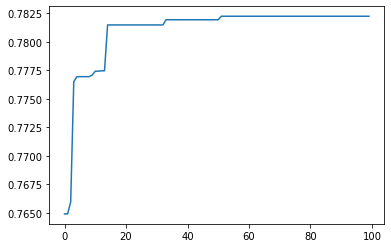

In [0]:

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness = ga.cal_pop_fitness(new_population, features, labels)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))[0]
best_match_idx = best_match_idx[0]

best_solution = new_population[best_match_idx, :]
best_solution_indices = np.where(best_solution == 1)[0]
best_solution_num_elements = best_solution_indices.shape[0]
best_solution_fitness = fitness[best_match_idx]

print("best_match_idx : ", best_match_idx)
print("best_solution : ", best_solution)
print("Selected indices : ", best_solution_indices)
print("Number of selected elements : ", best_solution_num_elements)
print("Best solution fitness : ", best_solution_fitness)

plt.plot(best_outputs)

In [0]:
import numpy
import sklearn.svm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

"""
SV_classifier = sklearn.svm.SVC(gamma='scale')
SV_classifier.fit(X=X_train, y=y_train)

predictions = SV_classifier.decision_function(X_test)#.predict(X_test)
score = roc_auc_score(y_test, predictions) # classification_accuracy(y_test, predictions)
print(score)
"""

"\nSV_classifier = sklearn.svm.SVC(gamma='scale')\nSV_classifier.fit(X=X_train, y=y_train)\n\npredictions = SV_classifier.decision_function(X_test)#.predict(X_test)\nscore = roc_auc_score(y_test, predictions) # classification_accuracy(y_test, predictions)\nprint(score)\n"

In [0]:
predictions = model_bdt.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, predictions)
print(score)

0.7805039397441069


In [0]:
fitness = pd.DataFrame(best_outputs)

In [0]:
fitness.to_hdf('xgb_sol_12_parents_6_mutations_3.h5', 'frame')